# Causal Inference for Tabular Data

Causal inference involves finding the effect of intervention on one set of variables, on another variable. For instance, if A->B->C. Then all the three variables may be correlated, but intervention on C, does not affect the values of B, since C is not a causal ancestor of of B. But on the other hand, interventions on A or B, both affect the values of C. 

While there are many different kinds of causal inference questions one may be interested in, we currently support three kinds-- 
1. Average Treatment Effect (ATE), 
2. Conditional ATE (CATE), and 
3. Couterfactuals. 

In **ATE**, we intervene on one set of variables with a treatment value and a control value, and estimate the expected change in value of some specified target variable. Mathematically,

$$\texttt{ATE} = \mathbb{E}[Y | \texttt{do}(X=x_t)] - \mathbb{E}[Y | \texttt{do}(X=x_c)]$$

where $\texttt{do}$ denotes the intervention operation. In words, ATE aims to determine the relative expected difference in the value of $Y$ when we intervene $X$ to be $x_t$ compared to when we intervene $X$ to be $x_c$. Here $x_t$ and $x_c$ are respectively the treatment value and control value.

**CATE** makes a similar estimate, but under some condition specified for a set of variables. Mathematically,

$$\texttt{CATE} = \mathbb{E}[Y | \texttt{do}(X=x_t), C=c] - \mathbb{E}[Y | \texttt{do}(X=x_c), C=c]$$

where we condition on some set of variables $C$ taking value $c$. Notice here that $X$ is intervened but $C$ is not. 

While ATE and CATE estimate expectation over the population, **Counterfactuals** aim at estimating the effect of an intervention on a specific instance or sample. Suppose we have a specific instance of a system of random variables $(X_1, X_2,...,X_N)$ given by $(X_1=x_1, X_2=x_2,...,X_N=x_N)$, then in a counterfactual, we want to know the effect an intervention (say) $X_1=k$ would have had on some other variable(s) (say $X_2$), holding all the remaining variables fixed. Mathematically, this can be expressed as,

$$\texttt{Counterfactual} = X_2 | \texttt{do}(X_1=k), X_3=x_3, X_4=4,\cdots,X_N=x_N$$

To understand how causal inference works in the case of time series, let's consider the following graph as an example:

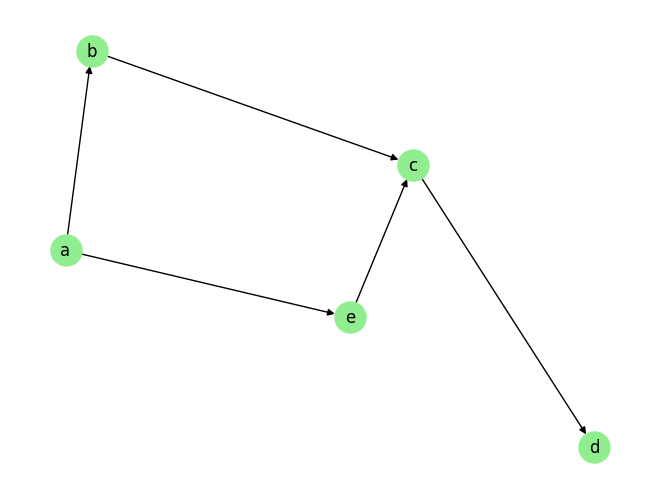

In [1]:
from causalai.misc.misc import plot_graph
from causalai.data.data_generator import DataGenerator

    
fn = lambda x:x
coef = 1.
sem = {
        'a': [], 
        'b': [('a', coef, fn),],
        'c': [('b', coef, fn), ('e', coef, fn),],
        'd': [('c', coef, fn),],
        'e': [('a', coef, fn),],
        }
T = 2000
data,var_names,graph_gt = DataGenerator(sem, T=T, seed=0)
plot_graph(graph_gt, node_size=500)

Given this graph with 5 variables-- a b, c, d and e, and some observational tabular data in the form for a $T \times 4$ 
matrix, suppose we want to estimate the causal effect of interventions of
the variable b on variable d. The SCM for this graph takes the form:

$$a = n_a $$
$$b = f_b(a) + n_b $$
$$c = f_c(b,e) + n_c $$
$$d = f_d(c) + n_d $$
$$e = n_e $$

Here $n_x$ are noise terms. Then intervening the values of the variable b at each time step, i.e., $do(b)$, causally affects
the values of $d$. This is because $d$ directly depends on $c$, and $c$ depends on $b$, thus there is an indirect 
causal effect. 

Notice that if we were to intervene both $a$ and $b$, the intervention of $a$ 
would not have any impact on $d$ because it is blocked by $b$, which is also intervened. On the other hand, if we 
were to intervene $c$ in addition to $b$ or $e$, then the intervention on $b$ and $e$ would not have any impact on $d$ because it 
would be blocked by $c$.

Coming back to the example shown in the above graph, we have established that an intervention on the values of $b$ 
impacts the values of $d$. Now suppose we want to calculate the treatment effect (say ATE) of this intervention on 
$d$. For the purpose of this exposition, let's consider just one of the terms in the ATE formula above, since both 
the terms have the same form. Specifically, we want to calculate,

$$\mathbb{E}[d | \texttt{do}(b)]$$
Conceptually, this is achieved by setting the value of $b=v$ ($v$ is the desired intervention value) in the observational data 
for all samples, then traverse the causal graph
in the order $b$, $c$, and $d$ (the causal order), for each observation. At edge $b->c$, we use the function $f_c$, to predict the causal effect of the intervened values of $b$ along with the observed value of $e$ on $c$. And similarly, at edge $c->d$, we use the function $f_d$, to predict the causal effect of the new values of $c$ on $d$. This finally yields the causal effect of the intervention of $b$ on the variable $d$ for all obervaational data. To compute the expectation $\mathbb{E}[d | \texttt{do}(b)]$, we simply take the average effect on $d$ over all the observational data.

Notice that we do not need 
to evaluate the equation for $a$ in this process because its value has on impact on $d$ once we intervene $b$. This saves computation. We would 
similarly have ignored any other variable during this computation if it was either not affected by the intervention, 
or if there was no causal path from that variable to the target variable $d$.


Now that we have a conceptual understanding, we point out that in reality, the functions $f_x$ for $x \in \{b,c,d \}$ are unknown in practice. In fact, given only observational data, we do not even know the causal graph as the one shown in the example above. Therefore, causal inference is treated as a two step process. First we estimate the causal graph using the observational data. We then use one of the various techniques to perform causal inference given both the observational data and the causal graph.

## Causal Inferencne methods supported by CausalAI

In our library, for tabular data, we support two methods for perform causal inference-- the **backdoor adjustment set method**, and another method that simulates the conceptual process described above for causal inference, that we will refer to as **causal_path method**.

#### causal_path method (defaut)

Let's begin with the causal_path method. Conceptually, this method works in two steps. For illustration, let's use the causal graph shown above as our example.
1. We train two models $P_{\theta_1}(c|b)$ and $P_{\theta_2}(d|c)$ to predict c from b, and d from c, using the observational data. We have not used the intervention information in this step.
2. we set the value of $b=v$ ($v$ is the desired intervention value) for all the samples in the observational data, then traverse the causal graph
in the order $b$, $c$, and $d$ (the causal order), for each observation. For each of the nodes c and d, we use the corresponding trained models $P_{\theta_1}(c|b)$ and $P_{\theta_2}(d|c)$ as proxies for the unknown functions $f_c$ and $f_d$, and follow the steps described above to estimate the causal effect.

#### Backdoor method
Given an intervention variable $X$ and a target variable $Y$, the backdoor method tries to find an adjustment set $Z$, that blocks all the backdoor paths between $X$ and $Y$, which are essentially the non-causal paths from $X$ to $Y$. Given such a set $Z$, we can use the the following result (Theorem 1) from Pearl 1995 (Causal diagrams for empirical research):

$$P(y | do(X)) = \sum_z P(y | X, Z). P(Z) \approx (1/T) . P(y | X, Z)$$

The backdoor criterion is defined as follows: A set of variables $Z$ satisfies the back-door criterion relative to an ordered pair of variables $(X_i,X_j)$ in a directed acyclic graph G if: (i) no node in $Z$ is a descendant of $X_i$, and (ii) $Z$ blocks every path between $X$, and $X_j$ which contains an arrow into $X$,. If $X$ and $Y$ are two disjoint sets of nodes in G, $Z$ is said to satisfy the back-door criterion relative to $(X, Y)$ if it satisfies it relative to any pair $(X_i,X_j)$ such that $X_i \in X$ and $X_j \in Y$.

For the causal graph in the example, the path $b <- a -> e -> c -> d$ is a valid backdoor path, since it contains an arrow into the intervention variable $b$, and $b$ and $d$ are the two end points of the path. The backdoor adjustment set corresponding to this path would be any one of $\{ a,e \}$, $\{ a \}$, and $\{ e \}$. This is because conditioning on any one of these sets blocks the path from aforementioned backdoor path. Note that variable $c$ cannot be part of the adjustment set as it is a descendant of the intervention variable $b$. For more details, see the documentation on tabular causal inference.

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pickle as pkl
import time
from functools import partial

from causalai.data.data_generator import DataGenerator, ConditionalDataGenerator
from causalai.models.tabular.causal_inference import CausalInference
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from causalai.misc.misc import plot_graph

def define_treatments(name, t,c):
    treatment = dict(var_name=name,
                    treatment_value=t,
                    control_value=c)
    return treatment



## Continuous Data

### Average Treatment Effect (ATE)
For this example, we will use synthetic data that has linear dependence among data variables.

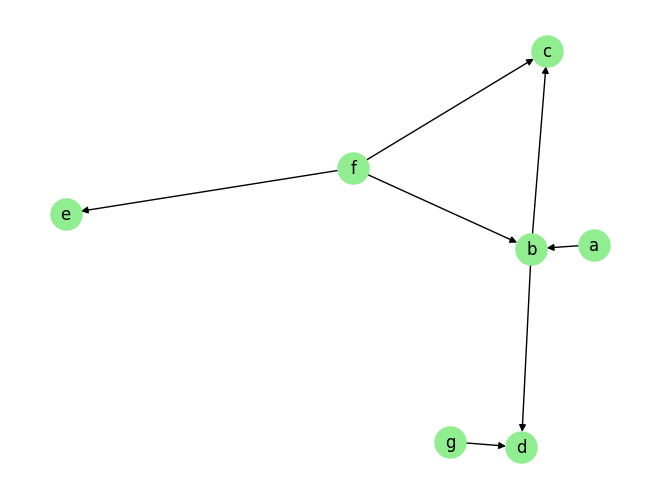

{'a': [],
 'b': ['a', 'f'],
 'c': ['b', 'f'],
 'd': ['b', 'g'],
 'e': ['f'],
 'f': [],
 'g': []}

In [3]:
fn = lambda x:x
coef = 0.5
sem = {
        'a': [], 
        'b': [('a', coef, fn), ('f', coef, fn)], 
        'c': [('b', coef, fn), ('f', coef, fn)],
        'd': [('b', coef, fn), ('g', coef, fn)],
        'e': [('f', coef, fn)], 
        'f': [],
        'g': [],
        }
T = 5000
data, var_names, graph_gt = DataGenerator(sem, T=T, seed=0, discrete=False)
plot_graph(graph_gt, node_size=500)
graph_gt

In [4]:

# Notice c does not depend on a if we intervene on b. Hence intervening a has no effect in this case. 
# This can be verified by changing the intervention values of variable a, which should have no impact on the 
# counterfactual. 
# (see graph_gt above)
t1='a' 
t2='b'
target = 'c'
target_var = var_names.index(target)

# treatment values
intervention11 = 100*np.ones(T)
intervention21 = 10*np.ones(T)
intervention_data1,_,_ = DataGenerator(sem, T=T, seed=0,
                        intervention={t1:intervention11, t2:intervention21})

# control values
intervention12 = -0.*np.ones(T)
intervention22 = -2.*np.ones(T)
intervention_data2,_,_ = DataGenerator(sem, T=T, seed=0,
                        intervention={t1:intervention12, t2:intervention22})



true_effect = (intervention_data1[:,target_var] - intervention_data2[:,target_var]).mean()
print("True ATE = %.2f" %true_effect)

True ATE = 6.00


We support two causal inference method-- backdoor method, and an in-house method that we call causal_path. We use both below.

In [5]:
treatments = [define_treatments(t1, intervention11,intervention12),\
             define_treatments(t2, intervention21,intervention22)]

tic = time.time()
# CausalInference_ = CausalInference(data, var_names, graph_gt,\
#         partial(MLPRegressor, hidden_layer_sizes=(100,100)) , False)
CausalInference_ = CausalInference(data, var_names, graph_gt, LinearRegression , discrete=False, method='causal_path')

ate, y_treat,y_control = CausalInference_.ate(target, treatments)
print(f'Estimated ATE using causal_path method: {ate:.2f}')
toc = time.time()
print(f'{toc-tic:.2f}s')


tic = time.time()
# CausalInference_ = CausalInference(data, var_names, graph_gt,\
#         partial(MLPRegressor, hidden_layer_sizes=(100,100)) , False)
CausalInference_ = CausalInference(data, var_names, graph_gt, LinearRegression , discrete=False, method='backdoor')

ate, y_treat,y_control = CausalInference_.ate(target, treatments)
print(f'Estimated ATE using backdoor method: {ate:.2f}')
toc = time.time()
print(f'{toc-tic:.2f}s')



Estimated ATE using causal_path method: 6.38
0.01s
Estimated ATE using backdoor method: 7.21
0.01s


**NOTE**: We find the backdoor method to exhibit a high variance in the ATE etimation, and this variance reduces with larger number of data samples. Therefore, the results from the Backdoor method may seem off at times, especially with smaller sample size. We find the causal_path method on the other hand to be much more robust.

### Conditional Average Treatement Effect (CATE)

The data is generated using the following structural equation model:
$$C = noise$$
$$W = C + noise$$
$$X = C*W + noise$$
$$Y = C*X + noise$$

We will treat C as the condition variable, X as the intervention variable, and Y as the target variable in our example below. The noise used in our example is sampled from the standard Gaussian distribution.

In [6]:
T=500
data, var_names, graph_gt = ConditionalDataGenerator(T=T, data_type='tabular', seed=0, discrete=False)
# var_names = ['C', 'W', 'X', 'Y']
treatment_var='X'
target = 'Y'
target_idx = var_names.index(target)


intervention1 = 0.1*np.ones(T, dtype=int)
intervention_data1,_,_ = ConditionalDataGenerator(T=T, data_type='tabular',\
                                    seed=0, intervention={treatment_var:intervention1}, discrete=False)

intervention2 = 0.9*np.ones(T, dtype=int)
intervention_data2,_,_ = ConditionalDataGenerator(T=T, data_type='tabular',\
                                    seed=0, intervention={treatment_var:intervention2}, discrete=False)
graph_gt

{'C': [], 'W': ['C'], 'X': ['C', 'W'], 'Y': ['C', 'X']}

In [7]:
condition_state=2.1
diff = np.abs(data[:,0] - condition_state)
idx = np.argmin(diff)
# assert diff[idx]<0.1, f'No observational data exists for the conditional variable close to {condition_state}'


cate_gt = (intervention_data1[idx,target_idx] - intervention_data2[idx,target_idx])
print(f'Approx True CATE: {cate_gt:.2f}')

####
treatments = define_treatments(treatment_var, intervention1,intervention2)
conditions = {'var_name': 'C', 'condition_value': condition_state}

tic = time.time()
model = partial(MLPRegressor, hidden_layer_sizes=(100,100), max_iter=200)
CausalInference_ = CausalInference(data, var_names, graph_gt, model, discrete=False, method='causal_path')#

cate = CausalInference_.cate(target, treatments, conditions, model)
toc = time.time()
print(f'Estimated CATE using causal_path method: {cate:.2f}')
print(f'Time taken: {toc-tic:.2f}s')

tic = time.time()
model = partial(MLPRegressor, hidden_layer_sizes=(100,100), max_iter=200)
CausalInference_ = CausalInference(data, var_names, graph_gt, model, discrete=False, method='backdoor')#

cate = CausalInference_.cate(target, treatments, conditions, model)
toc = time.time()
print(f'Estimated CATE using backdoor method: {cate:.2f}')
print(f'Time taken: {toc-tic:.2f}s')

Approx True CATE: -1.65
Estimated CATE using causal_path method: -1.61
Time taken: 0.54s
Estimated CATE using backdoor method: -1.31
Time taken: 0.45s


NOTE: We find the backdoor method to exhibit a high variance, and this variance reduces with larger number of data samples. Therefore, the results from the Backdoor method may seem off at times, especially with smaller sample size. We find the causal_path method on the other hand to be much more robust.

### Counterfactual



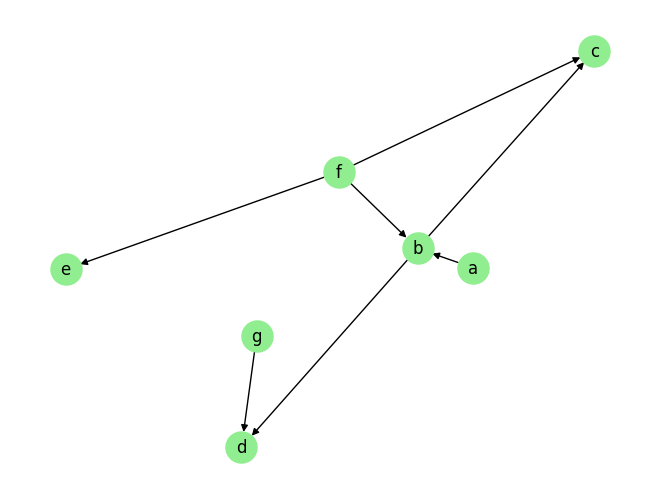

In [8]:

# sem_dict = GenerateRandomTabularSEM(var_names=['a', 'b', 'c', 'd', 'e', 'f'],\
#                                max_num_parents=4, seed=3, fn = lambda x:x, coef=0.8)
# data, var_names, graph_gt = DataGenerator(sem_dict, T=10000, noise_fn=None,\
#                                     intervention=None, discrete=False, nstates=10, seed=1)

fn = lambda x:x
coef = 0.5
sem = {
        'a': [], 
        'b': [('a', coef, fn), ('f', coef, fn)], 
        'c': [('b', coef, fn), ('f', coef, fn)],
        'd': [('b', coef, fn), ('g', coef, fn)],
        'e': [('f', coef, fn)], 
        'f': [],
        'g': [],
        }
T = 400
data, var_names, graph_gt = DataGenerator(sem, T=T, seed=0, discrete=False)
plot_graph(graph_gt, node_size=500)
graph_gt

intervention={'a':np.array([10.]*10), 'e':np.array([-0.]*10)}
target_var = 'c'

sample, _, _= DataGenerator(sem, T=10, noise_fn=None,\
                                    intervention=None, discrete=False, nstates=10, seed=1)
sample_intervened, _, _= DataGenerator(sem, T=10, noise_fn=None,\
                                    intervention=intervention, discrete=False, nstates=10, seed=1)

sample=sample[0]
sample_intervened=sample_intervened[0]
var_orig = sample[var_names.index(target_var)]
var_counterfactual_gt = sample_intervened[var_names.index(target_var)]
# print(f'Original value of var {target_var}: {var_orig:.2f}')

In [9]:
interventions = {name:float(val[0]) for name, val in intervention.items()}
print(f'True counterfactual {var_counterfactual_gt:.2f}')

# model = partial(MLPRegressor, hidden_layer_sizes=(100,100), max_iter=200)
model = LinearRegression

CausalInference_ = CausalInference(data, var_names, graph_gt, model, discrete=False, method='causal_path')
# model = None
counterfactual_et = CausalInference_.counterfactual(sample, target_var, interventions, model)

print(f'Estimated counterfactual using the causal_path method {counterfactual_et:.2f}')


CausalInference_ = CausalInference(data, var_names, graph_gt, model, discrete=False, method='backdoor')
# model = None
counterfactual_et = CausalInference_.counterfactual(sample, target_var, interventions, model)
print(f'Estimated counterfactual using the backdoor method {counterfactual_et:.2f}')

True counterfactual 3.33
Estimated counterfactual using the causal_path method 3.13
Estimated counterfactual using the backdoor method 1.45


NOTE: We find the backdoor method to exhibit a high variance, and this variance reduces with larger number of data samples. Therefore, the results from the Backdoor method may seem off at times, especially with smaller sample size. We find the causal_path method on the other hand to be much more robust.

## Discrete Data

The synthetic data generation procedure for the ATE, CATE and Counterfactual examples below are identical to the procedure followed above for the continuous case, except that the generated data is discrete in the cases below. 

**Importantly**, when referring as discrete, we only treat the intervention variables as discrete in this case. The target variables and other variables are considered as continuous. Specifically, it doesn't make sense for the target variable to be discrete when we compute ATE or CATE, because it involves estimating the difference in states of the target variable, and for discrete variables, the difference between two states is not a meaningful quantity (as discrete states are symbolic in nature).

### Average Treatment Effect (ATE)
 For this example, we will use synthetic data that has linear dependence among data variables.

In [10]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pickle as pkl
import time
from functools import partial

from causalai.data.data_generator import DataGenerator, ConditionalDataGenerator
from causalai.models.tabular.causal_inference import CausalInference
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from causalai.misc.misc import plot_graph

def define_treatments(name, t,c):
    treatment = dict(var_name=name,
                    treatment_value=t,
                    control_value=c)
    return treatment

In [11]:
fn = lambda x:x
coef = 0.6
sem = {
        'a': [], 
        'b': [('a', coef, fn), ('f', coef, fn)], 
        'c': [('b', coef, fn), ('f', coef, fn)],
        'd': [('b', coef, fn), ('b', coef, fn), ('g', coef, fn)],
        'e': [('f', coef, fn)], 
        'f': [],
        'g': [],
        }
T = 5000

t1='a'
t2='b'
target = 'c'
discrete = {name:True if name in [t1,t2] else False for name in sem.keys()}

data, var_names, graph_gt = DataGenerator(sem, T=T, seed=0, discrete=discrete, nstates=10)

graph_gt

{'a': [],
 'b': ['a', 'f'],
 'c': ['b', 'f'],
 'd': ['b', 'b', 'g'],
 'e': ['f'],
 'f': [],
 'g': []}

Notice how we specify the variable discrete above. We specify the intervention variables as discrete, while the others as continuous, as per our explanation above.

In [12]:


target_var = var_names.index(target)
# note that states can be [0,1,...,9], so the multiples below must be in this range
intervention11 = 0*np.ones(T, dtype=int)
intervention21 = 1*np.ones(T, dtype=int)
intervention_data1,_,_ = DataGenerator(sem, T=T, seed=0,
                            intervention={t1: intervention11, t2:intervention21}, discrete=discrete, nstates=10)

intervention12 = 9*np.ones(T, dtype=int)
intervention22 = 9*np.ones(T, dtype=int)
intervention_data2,_,_ = DataGenerator(sem, T=T, seed=0,
                            intervention={t1:intervention12, t2:intervention22}, discrete=discrete, nstates=10)

true_effect = (intervention_data1[:,target_var] - intervention_data2[:,target_var]).mean()
print("Ground truth ATE = %.2f" %true_effect)

Ground truth ATE = -2.83


In [13]:

tic = time.time()

treatments = [define_treatments(t1, intervention11,intervention12),\
             define_treatments(t2, intervention21,intervention22)]
model = partial(MLPRegressor, hidden_layer_sizes=(100,100), max_iter=200) # LinearRegression
CausalInference_ = CausalInference(data, var_names, graph_gt, model, discrete=True)#
o, y_treat,y_control = CausalInference_.ate(target, treatments)
print(f'Estimated ATE: {o:.2f}')
toc = time.time()
print(f'Time taken: {toc-tic:.2f}s')


Estimated ATE: -2.17
Time taken: 1.41s


### CATE (conditional ATE)
For this example we will use synthetic data that has non-linear dependence among data variables.

In [14]:
T=5000
treatment_var='X'
target = 'Y'
target_idx = ['C', 'W', 'X', 'Y'].index(target)

discrete = {name:True if name==treatment_var else False for name in ['C', 'W', 'X', 'Y']}
data, var_names, graph_gt = ConditionalDataGenerator(T=T, data_type='tabular', seed=0, discrete=discrete, nstates=10)
# var_names = ['C', 'W', 'X', 'Y']



# note that states can be [0,1,...,9], so the multiples below must be in this range
intervention1 = 9*np.ones(T, dtype=int)
intervention_data1,_,_ = ConditionalDataGenerator(T=T, data_type='tabular',\
                                    seed=0, intervention={treatment_var:intervention1}, discrete=discrete, nstates=10)

intervention2 = 1*np.ones(T, dtype=int)
intervention_data2,_,_ = ConditionalDataGenerator(T=T, data_type='tabular',\
                                    seed=0, intervention={treatment_var:intervention2}, discrete=discrete, nstates=10)
graph_gt

{'C': [], 'W': ['C'], 'X': ['C', 'W'], 'Y': ['C', 'X']}

In [15]:
condition_var = 'C'
condition_var_idx = var_names.index(condition_var)
# print(data[:,condition_var_idx].min(), data[:,condition_var_idx].max())
condition_state=0.5
idx = np.argmin(np.abs(data[:,condition_var_idx]-condition_state))
cate_gt = (intervention_data1[idx,target_idx] - intervention_data2[idx,target_idx]).mean()
print(f'Approx True CATE: {cate_gt:.2f}')

####
treatments = define_treatments(treatment_var, intervention1,intervention2)
conditions = {'var_name': condition_var, 'condition_value': condition_state}

tic = time.time()
model = partial(MLPRegressor, hidden_layer_sizes=(100,100), max_iter=200)
CausalInference_ = CausalInference(data, var_names, graph_gt, model, discrete=True)

cate = CausalInference_.cate(target, treatments, conditions, model)
toc = time.time()
print(f'Estimated CATE: {cate:.2f}')
print(f'Time taken: {toc-tic:.2f}s')

Approx True CATE: 4.61
Estimated CATE: 1.55
Time taken: 5.98s


### Couterfactual

In [16]:
fn = lambda x:x
coef = 0.5
sem = {
        'a': [], 
        'b': [('a', coef, fn), ('f', coef, fn)], 
        'c': [('b', coef, fn), ('f', coef, fn)],
        'd': [('b', coef, fn), ('g', coef, fn)],
        'e': [('f', coef, fn)], 
        'f': [],
        'g': [],
        }

intervention={'a':np.array([0]*10), 'e':np.array([0]*10)}
target_var = 'c'
discrete = {name:True if name in intervention.keys() else False for name in sem.keys()}

T = 5000
data, var_names, graph_gt = DataGenerator(sem, T=T, seed=0, discrete=discrete)
# plot_graph(graph_gt, node_size=500)
# graph_gt


sample, _, _= DataGenerator(sem, T=10, noise_fn=None,\
                                    intervention=None, discrete=discrete, nstates=10, seed=1)
sample_intervened, _, _= DataGenerator(sem, T=10, noise_fn=None,\
                                    intervention=intervention, discrete=discrete, nstates=10, seed=1)

sample=sample[-1]
sample_intervened=sample_intervened[-1]
var_orig = sample[var_names.index(target_var)]
var_counterfactual_gt = sample_intervened[var_names.index(target_var)]
# print(f'Original value of target var {target_var}: {var_orig:.2f}')

In [17]:
interventions = {name:float(val[0]) for name, val in intervention.items()}

# model = partial(MLPRegressor, hidden_layer_sizes=(100,100), max_iter=200)
model = LinearRegression
# model=None
CausalInference_ = CausalInference(data, var_names, graph_gt, model, discrete=True)
counterfactual_et = CausalInference_.counterfactual(sample, target_var, interventions, model)
print(f'True counterfactual {var_counterfactual_gt:.2f}')
print(f'Estimated counterfactual {counterfactual_et:.2f}')

True counterfactual -0.68
Estimated counterfactual -0.75
